## Import Libraries


In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import RocCurveDisplay

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [3]:
spark = SparkSession.builder.appName("Hotel Booking Analysis").getOrCreate()

## Load Data

In [4]:
df = spark.read.csv("hotel_bookings.csv", header=True, inferSchema=True)
df.show(5)

+------------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+----+---------------------------+-------------------------+------------------+-----------------------+
|       hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type| adr|required_car_parking_spaces|total_

In [5]:
df.columns

['hotel',
 'is_canceled',
 'lead_time',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'reserved_room_type',
 'assigned_room_type',
 'booking_changes',
 'deposit_type',
 'agent',
 'company',
 'days_in_waiting_list',
 'customer_type',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'reservation_status',
 'reservation_status_date']

# EDA

In [6]:
df.printSchema()

root
 |-- hotel: string (nullable = true)
 |-- is_canceled: integer (nullable = true)
 |-- lead_time: integer (nullable = true)
 |-- arrival_date_year: integer (nullable = true)
 |-- arrival_date_month: string (nullable = true)
 |-- arrival_date_week_number: integer (nullable = true)
 |-- arrival_date_day_of_month: integer (nullable = true)
 |-- stays_in_weekend_nights: integer (nullable = true)
 |-- stays_in_week_nights: integer (nullable = true)
 |-- adults: integer (nullable = true)
 |-- children: string (nullable = true)
 |-- babies: integer (nullable = true)
 |-- meal: string (nullable = true)
 |-- country: string (nullable = true)
 |-- market_segment: string (nullable = true)
 |-- distribution_channel: string (nullable = true)
 |-- is_repeated_guest: integer (nullable = true)
 |-- previous_cancellations: integer (nullable = true)
 |-- previous_bookings_not_canceled: integer (nullable = true)
 |-- reserved_room_type: string (nullable = true)
 |-- assigned_room_type: string (nullab

In [7]:
(rows, cols) = (df.count(), len(df.columns))
print(f"Shape: ({rows}, {cols})")

Shape: (119390, 32)


In [8]:
df.describe()

DataFrame[summary: string, hotel: string, is_canceled: string, lead_time: string, arrival_date_year: string, arrival_date_month: string, arrival_date_week_number: string, arrival_date_day_of_month: string, stays_in_weekend_nights: string, stays_in_week_nights: string, adults: string, children: string, babies: string, meal: string, country: string, market_segment: string, distribution_channel: string, is_repeated_guest: string, previous_cancellations: string, previous_bookings_not_canceled: string, reserved_room_type: string, assigned_room_type: string, booking_changes: string, deposit_type: string, agent: string, company: string, days_in_waiting_list: string, customer_type: string, adr: string, required_car_parking_spaces: string, total_of_special_requests: string, reservation_status: string]

In [9]:
string_cols = [c for c, t in df.dtypes if t == 'string']
if string_cols:
    df.select(string_cols).describe().toPandas().set_index("summary").T
else:
    print("Non!")

In [10]:
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()


+-----+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+---+---------------------------+-------------------------+------------------+-----------------------+
|hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|adr|required_car_parking_spaces|total_of_special_reque

## Missing Value 

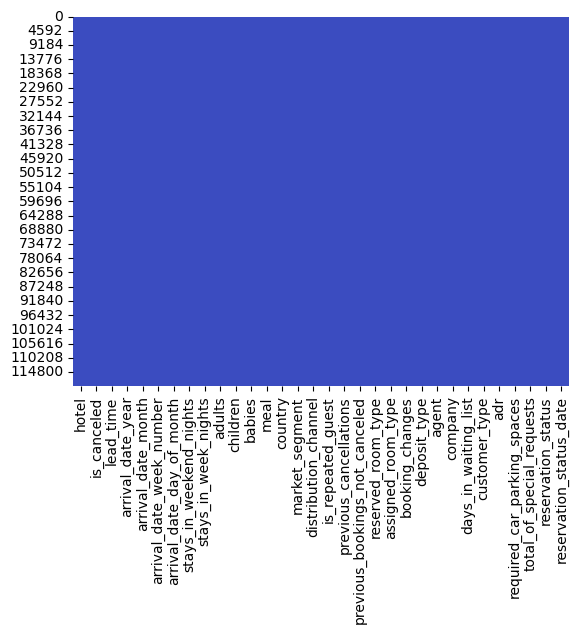

In [11]:
df_pandas = df.toPandas()
sns.heatmap(df_pandas.isnull(), cmap="coolwarm", cbar=False)
plt.show()

### Duplicated Columns

In [12]:
duplicate_count = df.groupBy(df.columns).count().filter("count > 1").selectExpr("sum(count - 1)").collect()[0][0]
print(f"{duplicate_count}")

31994


In [13]:
df = df.dropDuplicates()

# Preprocessing 

In [14]:
df.dtypes

[('hotel', 'string'),
 ('is_canceled', 'int'),
 ('lead_time', 'int'),
 ('arrival_date_year', 'int'),
 ('arrival_date_month', 'string'),
 ('arrival_date_week_number', 'int'),
 ('arrival_date_day_of_month', 'int'),
 ('stays_in_weekend_nights', 'int'),
 ('stays_in_week_nights', 'int'),
 ('adults', 'int'),
 ('children', 'string'),
 ('babies', 'int'),
 ('meal', 'string'),
 ('country', 'string'),
 ('market_segment', 'string'),
 ('distribution_channel', 'string'),
 ('is_repeated_guest', 'int'),
 ('previous_cancellations', 'int'),
 ('previous_bookings_not_canceled', 'int'),
 ('reserved_room_type', 'string'),
 ('assigned_room_type', 'string'),
 ('booking_changes', 'int'),
 ('deposit_type', 'string'),
 ('agent', 'string'),
 ('company', 'string'),
 ('days_in_waiting_list', 'int'),
 ('customer_type', 'string'),
 ('adr', 'double'),
 ('required_car_parking_spaces', 'int'),
 ('total_of_special_requests', 'int'),
 ('reservation_status', 'string'),
 ('reservation_status_date', 'date')]

In [15]:
# month_to_number = {
#     'January': 1,
#     'February': 2,
#     'March': 3,
#     'April': 4,
#     'May': 5,
#     'June': 6,
#     'July': 7,
#     'August': 8,
#     'September': 9,
#     'October': 10,
#     'November': 11,
#     'December': 12
# }
# df['arrival_date_month'] = df['arrival_date_month'].map(month_to_number)

In [16]:
df = df.fillna({"children": 0})  
df = df.withColumn("children", col("children").cast("int"))  
df = df.withColumn("reservation_status_date", to_date(col("reservation_status_date"), "yyyy-MM-dd"))

# Analysis & Visalizations

In [17]:
df.describe().show()

+-------+------------+-------------------+-----------------+------------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------------------+-------------------+--------------------+---------+-------+--------------+--------------------+-------------------+----------------------+------------------------------+------------------+------------------+-------------------+------------+------------------+------------------+--------------------+---------------+------------------+---------------------------+-------------------------+------------------+
|summary|       hotel|        is_canceled|        lead_time| arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|            adults|           children|              babies|     meal|country|market_segment|distribution_channel|  is_repeated_guest|previous_cancellations|previous_bookings_not_cancel

In [18]:
df.groupBy("is_canceled").count().orderBy("count", ascending=False).show()

+-----------+-----+
|is_canceled|count|
+-----------+-----+
|          0|63371|
|          1|24025|
+-----------+-----+



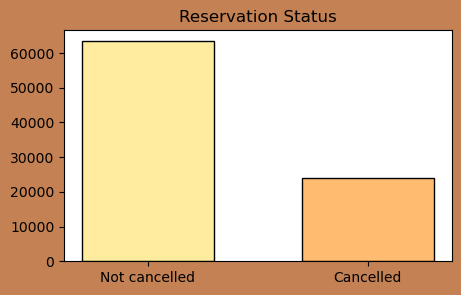

In [19]:
cancel_counts = df.groupBy("is_canceled").count()
total_count = df.count()
cancel_counts = cancel_counts.withColumn("percentage", col("count") / total_count)
cancel_counts_pd = cancel_counts.toPandas().sort_values("is_canceled")

plt.figure(figsize=(5, 3), facecolor="#C38154")
plt.title("Reservation Status")
plt.bar(['Not cancelled', 'Cancelled'], cancel_counts_pd["count"], edgecolor='k', width=0.6, color=["#FFEC9E", "#FFBB70"])
plt.show()


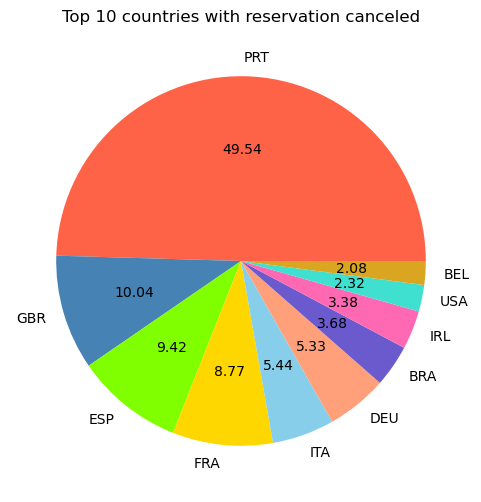

In [20]:
cancelled_data = df.filter(col("is_canceled") == 1)

top_10_country = (
    cancelled_data.groupBy("country")
    .count()
    .orderBy(col("count").desc())
    .limit(10)
)

top_10_country_pd = top_10_country.toPandas().set_index("country")

plt.figure(figsize=(6, 6))  
plt.title("Top 10 countries with reservation canceled", color="black")
plt.pie(
    top_10_country_pd["count"], 
    autopct="%.2f", 
    labels=top_10_country_pd.index, 
    colors=['#FF6347', '#4682B4', '#7FFF00', '#FFD700', '#87CEEB', 
            '#FFA07A', '#6A5ACD', '#FF69B4', '#40E0D0', '#DAA520']
)
plt.show()


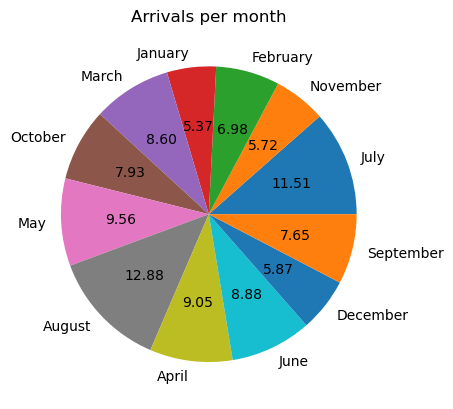

In [21]:
arrivals_per_month = df.groupBy("arrival_date_month").count()

arrivals_pd = arrivals_per_month.toPandas().set_index("arrival_date_month")

plt.pie(arrivals_pd["count"], labels=arrivals_pd.index, autopct="%0.2f")
plt.title("Arrivals per month")
plt.show()


C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\2883533441.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="market_segment", y="cancellation_rate", data=market_cancel_rate, palette="Set2")


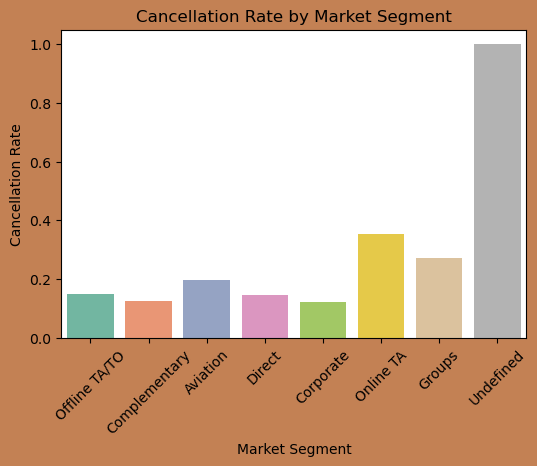

In [22]:
market_cancel_rate = (
    df.groupBy("market_segment")
    .agg((sum(col("is_canceled")) / count("*")).alias("cancellation_rate"))
    .toPandas()
)

plt.figure(figsize=(6, 4), facecolor="#C38154")
sns.barplot(x="market_segment", y="cancellation_rate", data=market_cancel_rate, palette="Set2")
plt.title("Cancellation Rate by Market Segment")
plt.xlabel("Market Segment")
plt.ylabel("Cancellation Rate")
plt.xticks(rotation=45)
plt.show()


C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\720017542.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="market_segment", y="average_adr", data=adr_by_market, palette="Set2")


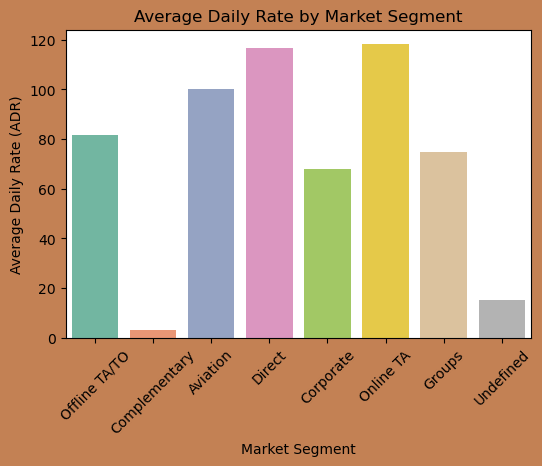

In [23]:
adr_by_market = (
    df.groupBy("market_segment")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(6, 4), facecolor="#C38154")
sns.barplot(x="market_segment", y="average_adr", data=adr_by_market, palette="Set2")
plt.title("Average Daily Rate by Market Segment")
plt.xlabel("Market Segment")
plt.ylabel("Average Daily Rate (ADR)")
plt.xticks(rotation=45)
plt.show()


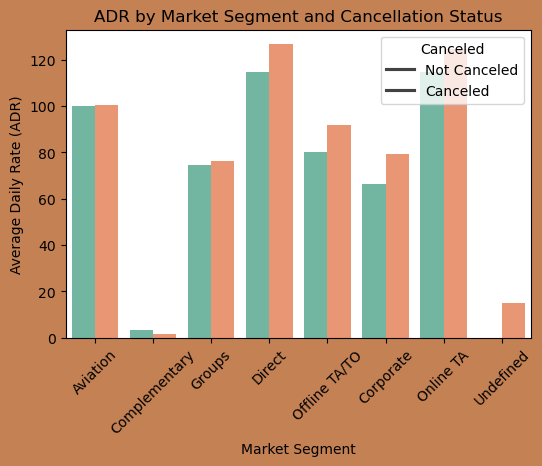

In [24]:
adr_by_segment_cancel = (
    df.groupBy("market_segment", "is_canceled")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(6, 4), facecolor="#C38154")
sns.barplot(x="market_segment", y="average_adr", hue="is_canceled", data=adr_by_segment_cancel, palette="Set2")
plt.title("ADR by Market Segment and Cancellation Status")
plt.xlabel("Market Segment")
plt.ylabel("Average Daily Rate (ADR)")
plt.xticks(rotation=45) 
plt.legend(title="Canceled", loc="upper right", labels=["Not Canceled", "Canceled"])
plt.show()


C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\2977437616.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="reserved_room_type", y="average_adr", data=adr_by_room_type, palette="Set2")


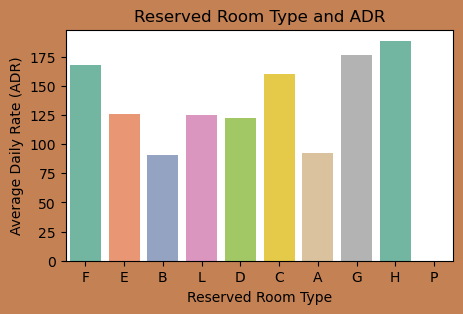

In [25]:
adr_by_room_type = (
    df.groupBy("reserved_room_type")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(5, 3), facecolor="#C38154")
sns.barplot(x="reserved_room_type", y="average_adr", data=adr_by_room_type, palette="Set2")
plt.title("Reserved Room Type and ADR")
plt.xlabel("Reserved Room Type")
plt.ylabel("Average Daily Rate (ADR)")
plt.show()


C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\4225271894.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="hotel", y="adr", data=adr_by_hotel, palette=custom_palette)


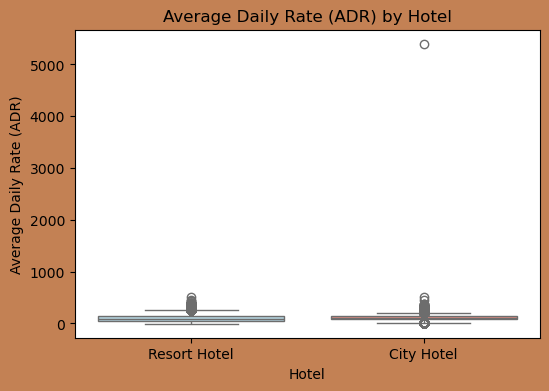

In [26]:
adr_by_hotel = df.select("hotel", "adr").toPandas()

custom_palette = {'Resort Hotel': 'lightblue', 'City Hotel': 'salmon'}

plt.figure(figsize=(6, 4), facecolor="#C38154")
sns.boxplot(x="hotel", y="adr", data=adr_by_hotel, palette=custom_palette)
plt.title("Average Daily Rate (ADR) by Hotel")
plt.xlabel("Hotel")
plt.ylabel("Average Daily Rate (ADR)")
plt.show()


In [27]:
from pyspark.sql.functions import col, max

max_adr_city_hotel = (
    df.filter(col("hotel") == "City Hotel")
    .agg(max("adr"))
    .collect()[0][0]
)

print(max_adr_city_hotel)


5400.0


In [28]:
max_adr_value = df.agg(max("adr")).collect()[0][0]
df_max_adr = df.filter(col("adr") == max_adr_value)
df_max_adr.show()


+----------+-----------+---------+-----------------+------------------+------------------------+-------------------------+-----------------------+--------------------+------+--------+------+----+-------+--------------+--------------------+-----------------+----------------------+------------------------------+------------------+------------------+---------------+------------+-----+-------+--------------------+-------------+------+---------------------------+-------------------------+------------------+-----------------------+
|     hotel|is_canceled|lead_time|arrival_date_year|arrival_date_month|arrival_date_week_number|arrival_date_day_of_month|stays_in_weekend_nights|stays_in_week_nights|adults|children|babies|meal|country|market_segment|distribution_channel|is_repeated_guest|previous_cancellations|previous_bookings_not_canceled|reserved_room_type|assigned_room_type|booking_changes|deposit_type|agent|company|days_in_waiting_list|customer_type|   adr|required_car_parking_spaces|total_

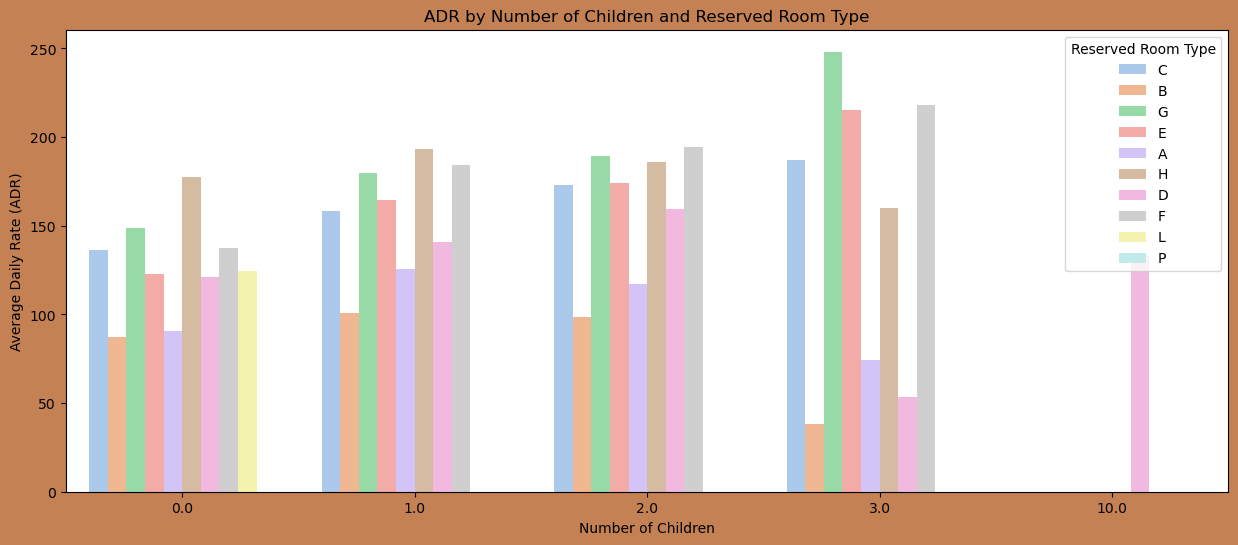

In [29]:
adr_by_children_room = (
    df.groupBy("children", "reserved_room_type")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(15, 6), facecolor="#C38154") 
sns.barplot(x="children", y="average_adr", hue="reserved_room_type", data=adr_by_children_room, palette="pastel")
plt.title("ADR by Number of Children and Reserved Room Type")
plt.xlabel("Number of Children")
plt.ylabel("Average Daily Rate (ADR)")
plt.legend(title="Reserved Room Type", loc="upper right")
plt.show()


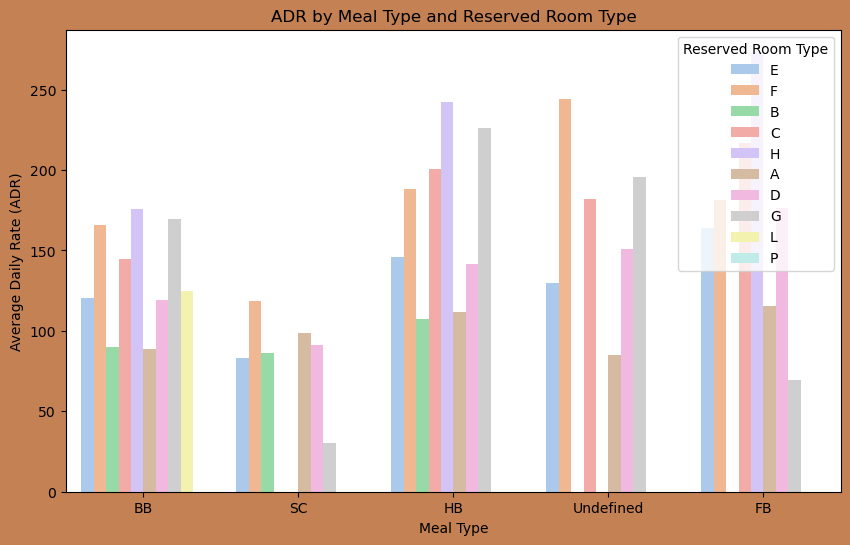

In [30]:
adr_by_meal_room = (
    df.groupBy("meal", "reserved_room_type")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(10, 6), facecolor="#C38154") 
sns.barplot(x="meal", y="average_adr", hue="reserved_room_type", data=adr_by_meal_room, palette="pastel")
plt.title("ADR by Meal Type and Reserved Room Type")
plt.xlabel("Meal Type")
plt.ylabel("Average Daily Rate (ADR)")
plt.legend(title="Reserved Room Type", loc="upper right")
plt.show()


C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\2086973455.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="customer_type", y="average_adr", data=adr_by_customer, palette="Set2", ci=None)
C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\2086973455.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="customer_type", y="average_adr", data=adr_by_customer, palette="Set2", ci=None)


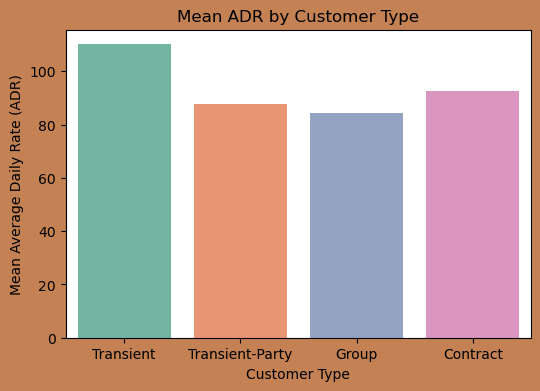

In [31]:
adr_by_customer = (
    df.groupBy("customer_type")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(6, 4), facecolor="#C38154")
sns.barplot(x="customer_type", y="average_adr", data=adr_by_customer, palette="Set2", ci=None)
plt.title("Mean ADR by Customer Type")
plt.xlabel("Customer Type")
plt.ylabel("Mean Average Daily Rate (ADR)")
plt.show()


C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\647836019.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="is_repeated_guest", y="average_adr", data=adr_by_repeated_guest, palette="Set2")


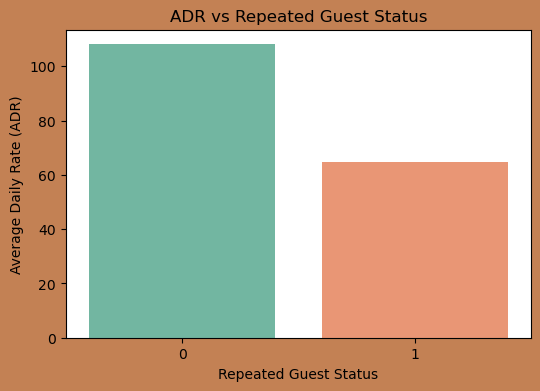

In [32]:
adr_by_repeated_guest = (
    df.groupBy("is_repeated_guest")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(6, 4), facecolor="#C38154")
sns.barplot(x="is_repeated_guest", y="average_adr", data=adr_by_repeated_guest, palette="Set2")
plt.title("ADR vs Repeated Guest Status")
plt.xlabel("Repeated Guest Status")
plt.ylabel("Average Daily Rate (ADR)")
plt.show()


C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\2958343777.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="is_repeated_guest", y="average_adr", hue="is_canceled", data=adr_by_repeated_guest_cancel, palette="Set2", ci=None)


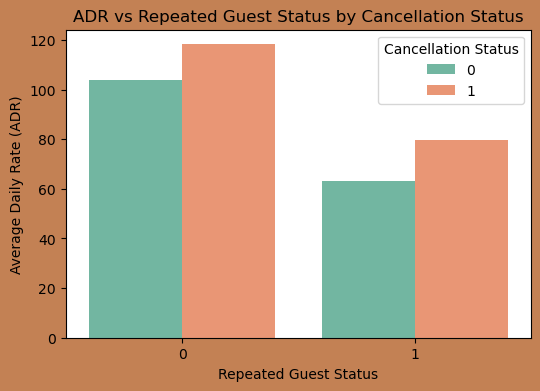

In [33]:
adr_by_repeated_guest_cancel = (
    df.groupBy("is_repeated_guest", "is_canceled")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .toPandas()
)

plt.figure(figsize=(6, 4), facecolor="#C38154")
sns.barplot(x="is_repeated_guest", y="average_adr", hue="is_canceled", data=adr_by_repeated_guest_cancel, palette="Set2", ci=None)
plt.title("ADR vs Repeated Guest Status by Cancellation Status")
plt.xlabel("Repeated Guest Status")
plt.ylabel("Average Daily Rate (ADR)")
plt.legend(title="Cancellation Status", loc="upper right")
plt.show()


## BoxPlot for Target col

C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\3127426762.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_canceled", y=column, data=data_pd, palette="Set2")
C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\3127426762.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_canceled", y=column, data=data_pd, palette="Set2")
C:\Users\vanhi\AppData\Local\Temp\ipykernel_3536\3127426762.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="is_canceled", y=column, data=data_pd, palette="Set2")
C:\Users\vanhi\AppData\Local\Temp\ipy

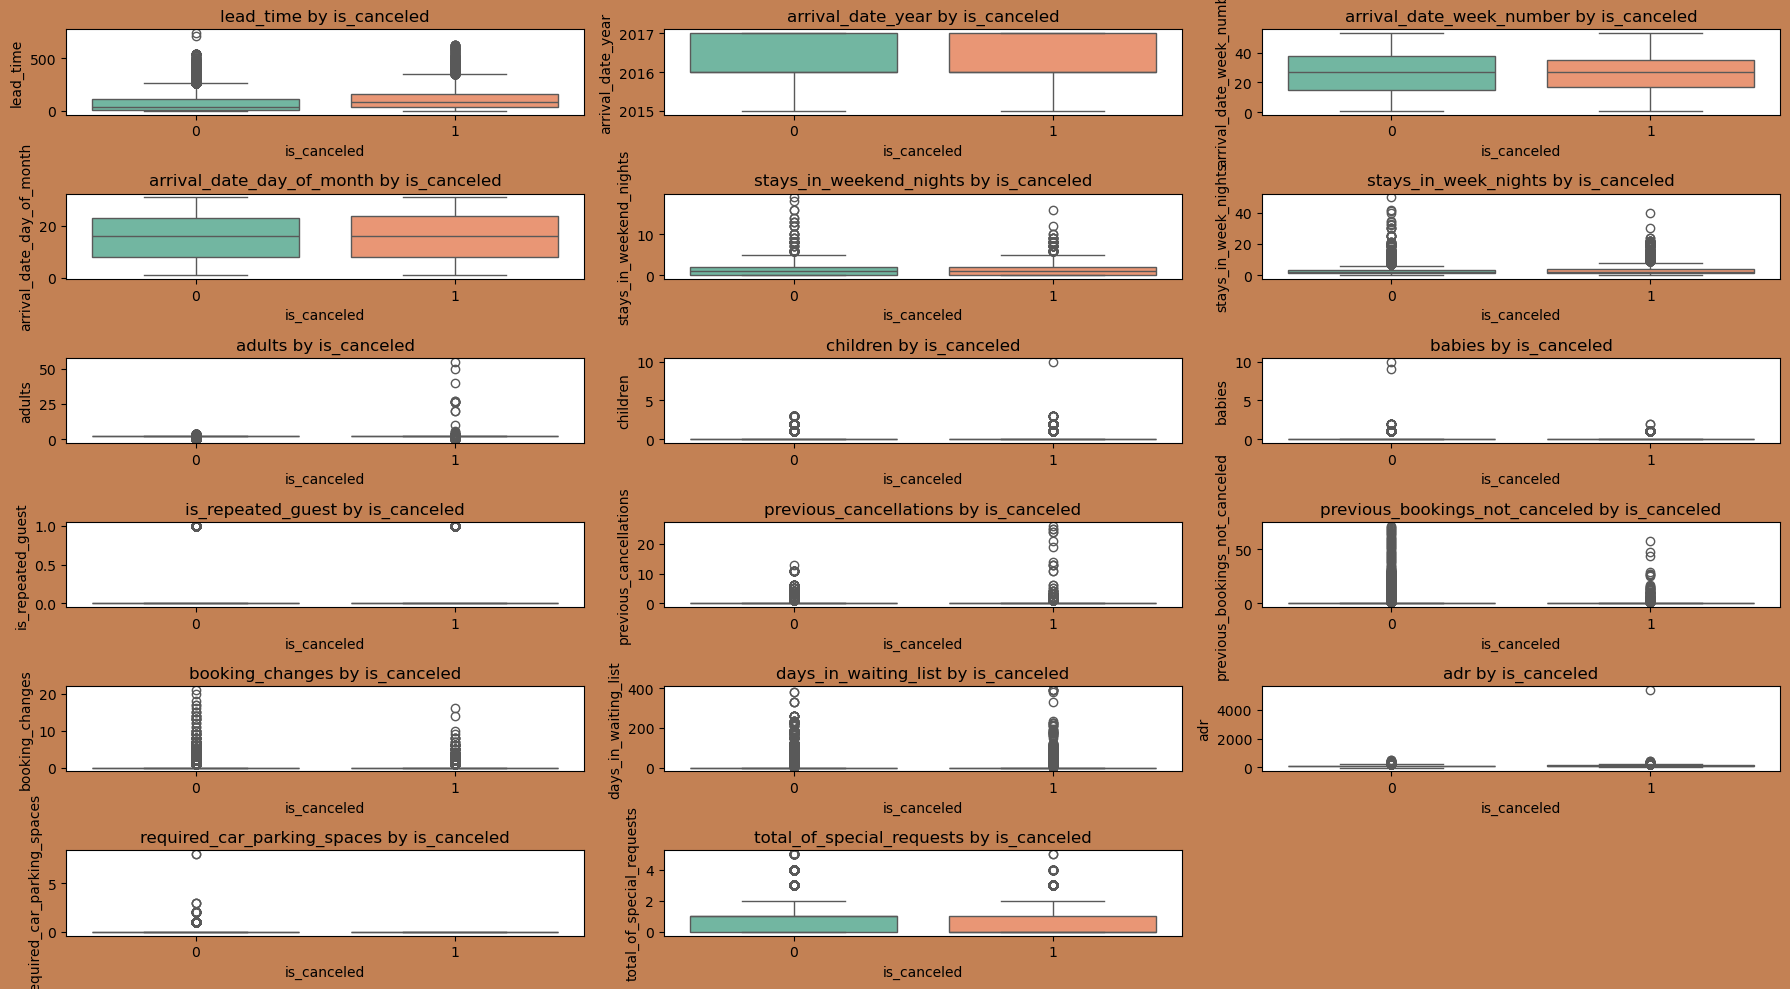

In [34]:
numerical_columns = [col_name for col_name, dtype in df.dtypes if dtype in ("int", "double") and col_name != "is_canceled"]

num_columns = len(numerical_columns)
n_rows = (num_columns + 2) // 3  

plt.figure(figsize=(18, 10), facecolor="#C38154")

for i, column in enumerate(numerical_columns, 1):
    data_pd = df.select("is_canceled", column).toPandas()
    plt.subplot(n_rows, 3, i)
    sns.boxplot(x="is_canceled", y=column, data=data_pd, palette="Set2")
    plt.title(f"{column} by is_canceled")
    plt.xlabel("is_canceled")
    plt.ylabel(column)

plt.tight_layout()
plt.show()


## Distribution of Cols by Target Col

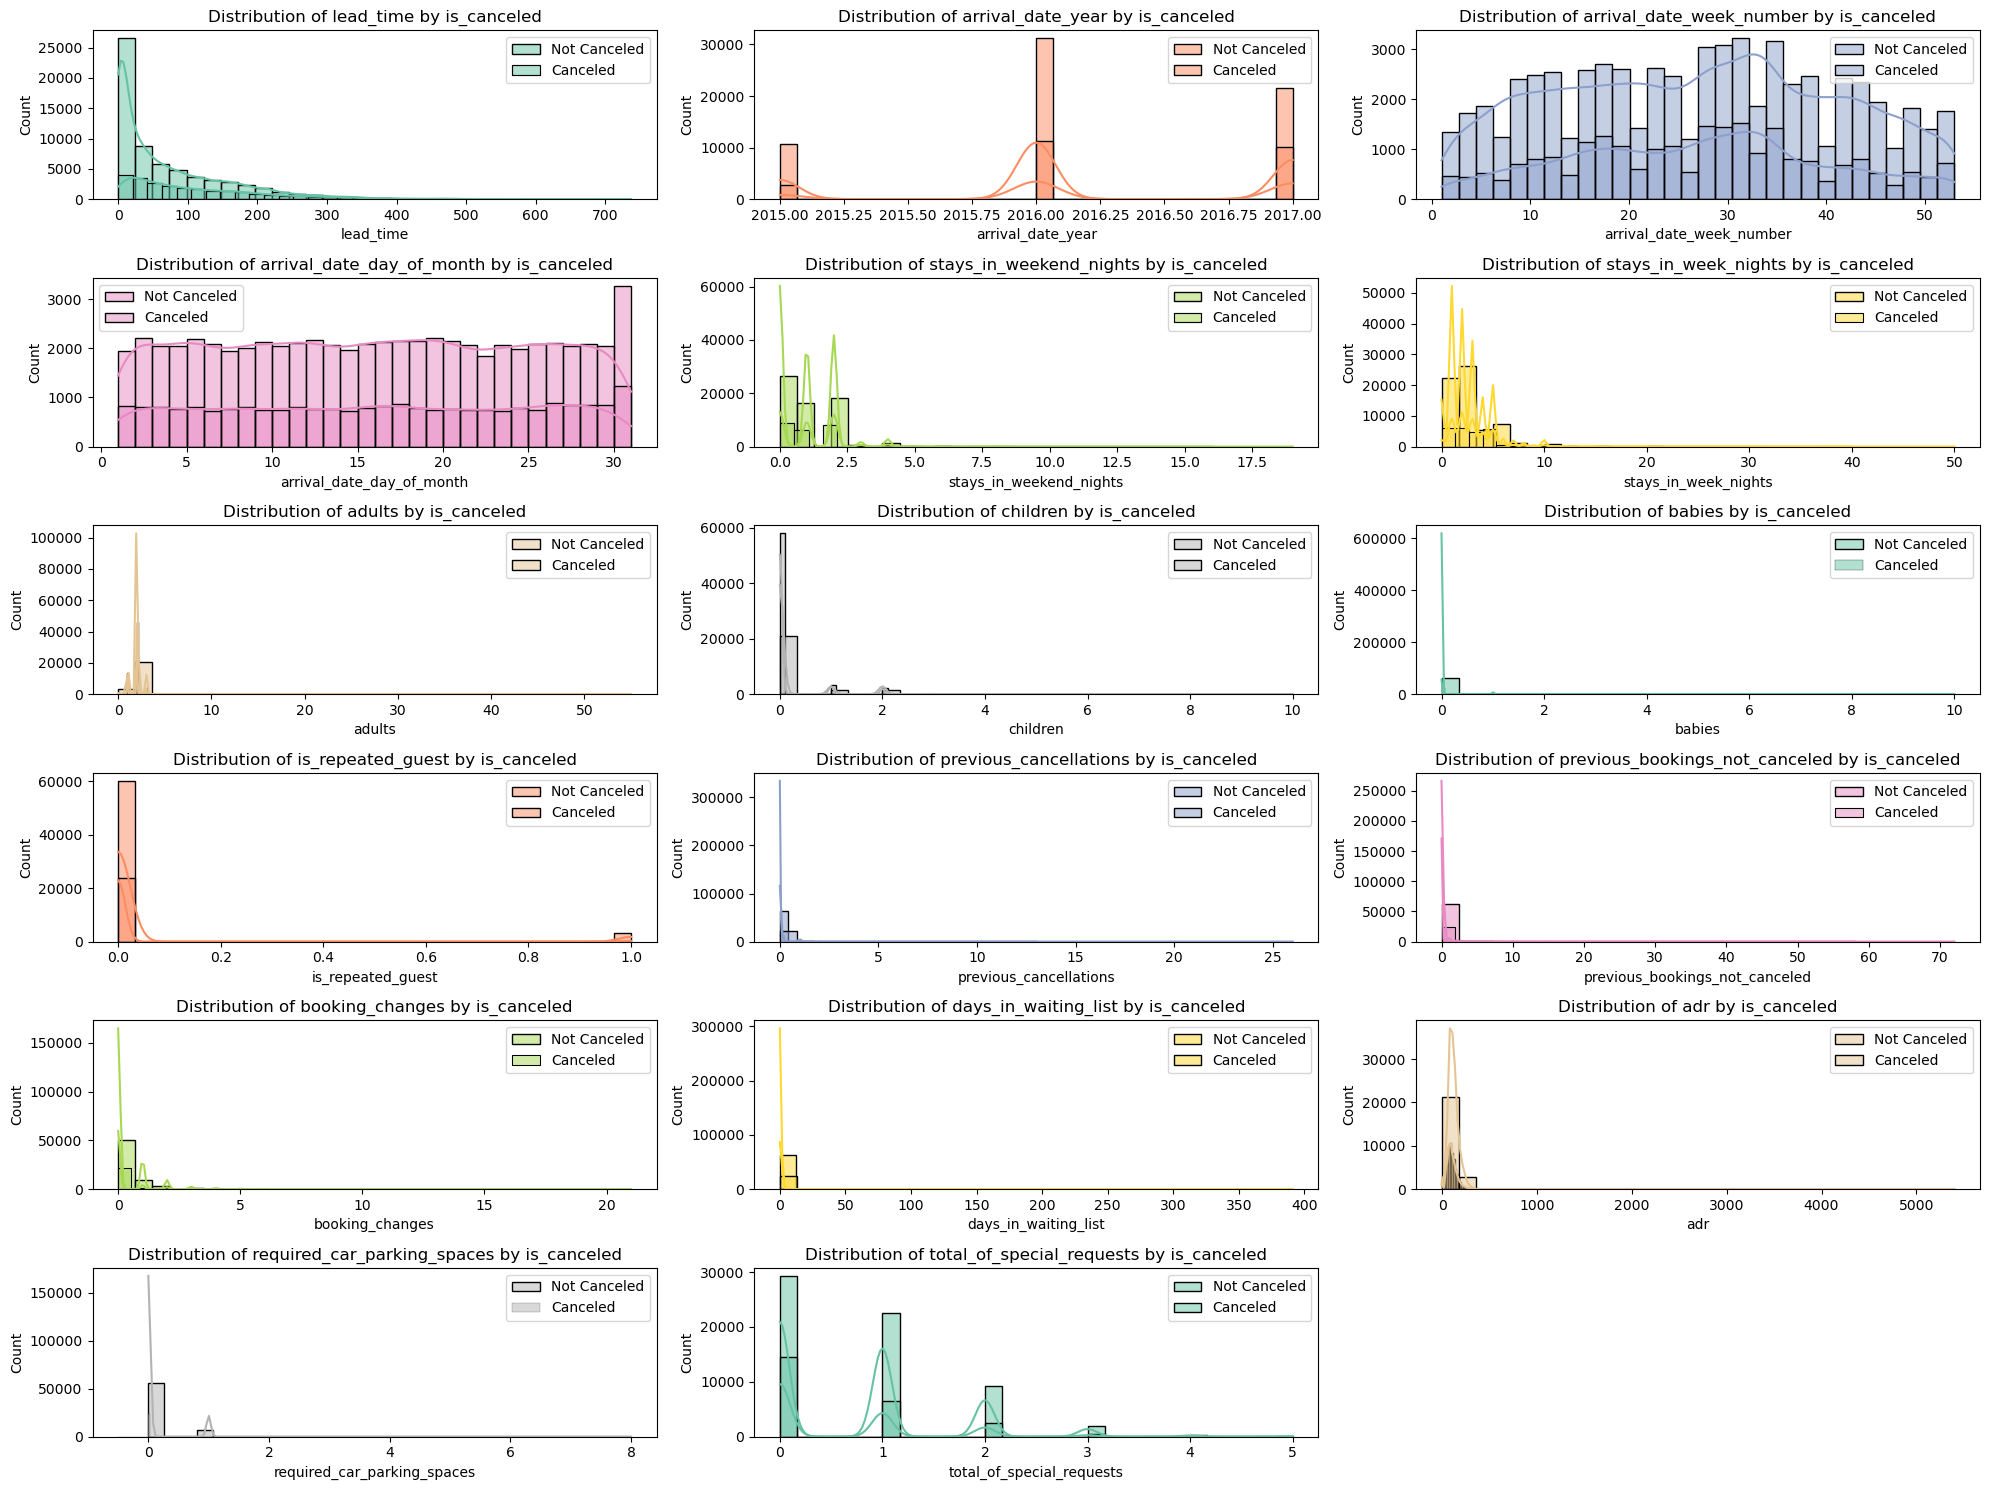

In [35]:
num_columns = len(numerical_columns)
n_cols = 3  
n_rows = (num_columns + n_cols - 1) // n_cols  

colors = sns.color_palette("Set2", n_colors=num_columns)  

plt.figure(figsize=(20, 15))

for i, col in enumerate(numerical_columns, 1):
    data_pd = df.select("is_canceled", col).toPandas()

    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data_pd[data_pd["is_canceled"] == 0][col], kde=True, bins=30, color=colors[i-1], label="Not Canceled")
    sns.histplot(data_pd[data_pd["is_canceled"] == 1][col], kde=True, bins=30, color=colors[i-1], label="Canceled", alpha=0.5)
    plt.title(f"Distribution of {col} by is_canceled")
    plt.legend()

plt.tight_layout()
plt.show()


## The average daily rate over time for canceled and not bookings from 2016 to September 2017.


In [36]:
from pyspark.sql.functions import col

cancelled_data_adr = (
    df.filter(col("is_canceled") == 1)
    .groupBy("reservation_status_date")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .orderBy("reservation_status_date")
    .toPandas()
)

not_cancelled_df_adr = (
    df.filter(col("is_canceled") == 0)
    .groupBy("reservation_status_date")
    .agg({"adr": "avg"})
    .withColumnRenamed("avg(adr)", "average_adr")
    .orderBy("reservation_status_date")
    .toPandas()
)


In [37]:
cancelled_data_adr["reservation_status_date"] = pd.to_datetime(cancelled_data_adr["reservation_status_date"])
not_cancelled_df_adr["reservation_status_date"] = pd.to_datetime(not_cancelled_df_adr["reservation_status_date"])

cancelled_df_adr = cancelled_data_adr[
    (cancelled_data_adr["reservation_status_date"] > "2016-01-01") &
    (cancelled_data_adr["reservation_status_date"] < "2017-09-01")
]

not_cancelled_df_adr = not_cancelled_df_adr[
    (not_cancelled_df_adr["reservation_status_date"] > "2016-01-01") &
    (not_cancelled_df_adr["reservation_status_date"] < "2017-09-01")
]


In [38]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

cancelled_data_adr = spark.createDataFrame(cancelled_data_adr)
not_cancelled_df_adr = spark.createDataFrame(not_cancelled_df_adr)

cancelled_data_adr.printSchema()


root
 |-- reservation_status_date: timestamp (nullable = true)
 |-- average_adr: double (nullable = true)



In [39]:
df.groupBy("reservation_status").count().orderBy("count", ascending=False).show()


+------------------+-----+
|reservation_status|count|
+------------------+-----+
|         Check-Out|63371|
|          Canceled|23011|
|           No-Show| 1014|
+------------------+-----+



In [40]:
numeric_cols = [field.name for field in df.schema.fields if field.dataType.simpleString() in ['int', 'double']]


In [41]:
df = df.fillna(0, subset=numeric_cols)


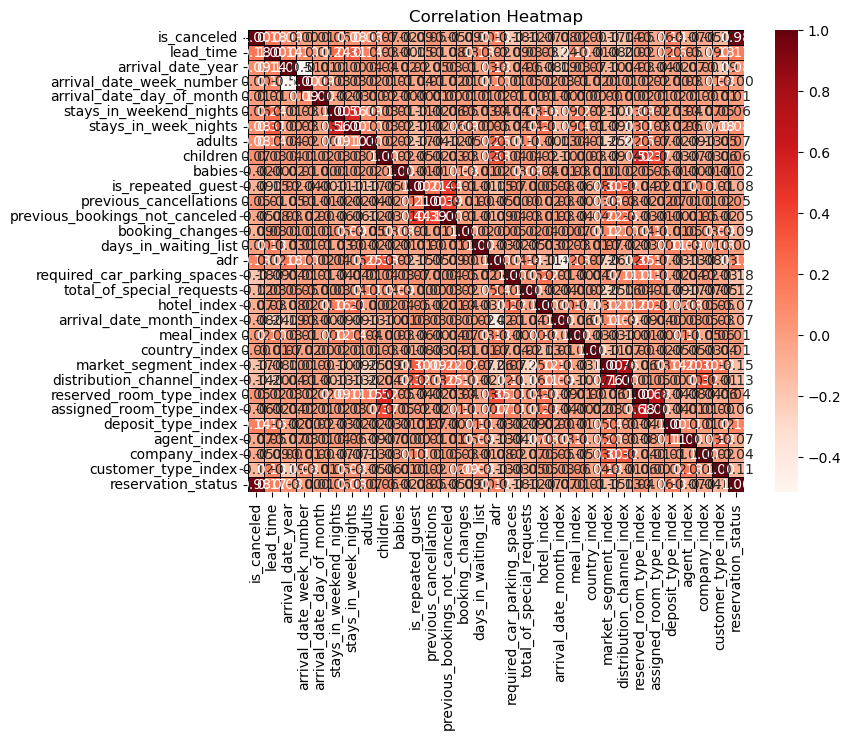

In [50]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

numeric_cols = [field.name for field in df.schema.fields if field.dataType.simpleString() in ['int', 'double']]

assembler = VectorAssembler(inputCols=numeric_cols, outputCol="features")
df_vector = assembler.transform(df).select("features")

corr_matrix = Correlation.corr(df_vector, "features").head()[0].toArray()

corr_df = pd.DataFrame(corr_matrix, index=numeric_cols, columns=numeric_cols)

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, cmap='Reds', linecolor='black', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()


# Predictive Modeling

## Data Preparation


In [43]:
df = df.drop("reservation_status_date")


- Label Encoder

In [44]:
from pyspark.ml.feature import StringIndexer

for column in [field.name for field in df.schema.fields if field.dataType.simpleString() == 'string']:
    indexer = StringIndexer(inputCol=column, outputCol=column + "_index")
    df = indexer.fit(df).transform(df).drop(column)

df = df.withColumnRenamed(column + "_index", column)


In [45]:
from pyspark.sql.functions import col

X = df.drop("is_canceled")
y = df.select("is_canceled")

train_df, test_df = df.randomSplit([0.8, 0.2], seed=0)


## Decision Tree

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics

feature_cols = [col for col in df.columns if col != "is_canceled"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_transformed = assembler.transform(df).select("features", "is_canceled")

train_df, test_df = df_transformed.randomSplit([0.8, 0.2], seed=42)

dt_model = DecisionTreeClassifier(labelCol="is_canceled", featuresCol="features", seed=42, maxBins=500)

dt_fitted = dt_model.fit(train_df)

predictions_train = dt_fitted.transform(train_df)
predictions_test = dt_fitted.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="is_canceled", predictionCol="prediction", metricName="accuracy")

accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

print(f"Decision Tree Training Accuracy: {accuracy_train:.2f}")
print(f"Decision Tree Test Accuracy: {accuracy_test:.2f}")

preds_and_labels = predictions_test.select("prediction", "is_canceled").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(preds_and_labels)

print("Confusion Matrix:\n", metrics.confusionMatrix().toArray())

predictions_test.select("is_canceled", "prediction").show(10)


Decision Tree Training Accuracy: 1.00
Decision Tree Test Accuracy: 1.00


c:\Users\vanhi\miniconda3\envs\workshop\Lib\site-packages\pyspark\sql\context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 468.0 failed 1 times, most recent failure: Lost task 0.0 in stage 468.0 (TID 900) (HiepLapTop executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more


In [55]:
print(type(dt_fitted))


<class 'pyspark.ml.classification.DecisionTreeClassificationModel'>


## Random Forest

In [56]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import IntegerType
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics

spark = SparkSession.builder.appName("RandomForest_PySpark").getOrCreate()

df = df.withColumn("is_canceled", col("is_canceled").cast(IntegerType()))

feature_cols = [col for col in df.columns if col != "is_canceled"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

df_transformed = assembler.transform(df).select("features", "is_canceled")

train_df, test_df = df_transformed.randomSplit([0.8, 0.2], seed=42)

rf_model = RandomForestClassifier(
    labelCol="is_canceled", 
    featuresCol="features", 
    numTrees=100,       
    maxDepth=5,         
    maxBins=500,        
    seed=42
)

rf_fitted = rf_model.fit(train_df)

predictions_train = rf_fitted.transform(train_df)
predictions_test = rf_fitted.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol="is_canceled", predictionCol="prediction", metricName="accuracy")

accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)

print(f"Random Forest Training Accuracy: {accuracy_train:.2f}")
print(f"Random Forest Test Accuracy: {accuracy_test:.2f}")

preds_and_labels = predictions_test.select("prediction", "is_canceled").rdd.map(lambda x: (float(x[0]), float(x[1])))
metrics = MulticlassMetrics(preds_and_labels)

print("Confusion Matrix:\n", metrics.confusionMatrix().toArray())

predictions_test.select("is_canceled", "prediction").show(10)


Random Forest Training Accuracy: 1.00
Random Forest Test Accuracy: 1.00


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.runJob.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 511.0 failed 1 times, most recent failure: Lost task 0.0 in stage 511.0 (TID 1007) (HiepLapTop executor driver): org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.failJobAndIndependentStages(DAGScheduler.scala:2856)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2(DAGScheduler.scala:2792)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$abortStage$2$adapted(DAGScheduler.scala:2791)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:2791)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$handleTaskSetFailed$1$adapted(DAGScheduler.scala:1247)
	at scala.Option.foreach(Option.scala:407)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:1247)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3060)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2994)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2983)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:989)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2393)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2414)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2433)
	at org.apache.spark.api.python.PythonRDD$.runJob(PythonRDD.scala:181)
	at org.apache.spark.api.python.PythonRDD.runJob(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.SparkException: Python worker failed to connect back.
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:203)
	at org.apache.spark.api.python.PythonWorkerFactory.create(PythonWorkerFactory.scala:109)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:124)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.scala:174)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:67)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:367)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:331)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:93)
	at org.apache.spark.TaskContext.runTaskWithListeners(TaskContext.scala:166)
	at org.apache.spark.scheduler.Task.run(Task.scala:141)
	at org.apache.spark.executor.Executor$TaskRunner.$anonfun$run$4(Executor.scala:620)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally(SparkErrorUtils.scala:64)
	at org.apache.spark.util.SparkErrorUtils.tryWithSafeFinally$(SparkErrorUtils.scala:61)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:94)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:623)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more
Caused by: java.net.SocketTimeoutException: Accept timed out
	at java.net.DualStackPlainSocketImpl.waitForNewConnection(Native Method)
	at java.net.DualStackPlainSocketImpl.socketAccept(DualStackPlainSocketImpl.java:135)
	at java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:409)
	at java.net.PlainSocketImpl.accept(PlainSocketImpl.java:199)
	at java.net.ServerSocket.implAccept(ServerSocket.java:545)
	at java.net.ServerSocket.accept(ServerSocket.java:513)
	at org.apache.spark.api.python.PythonWorkerFactory.createSimpleWorker(PythonWorkerFactory.scala:190)
	... 17 more
